# GRU Implementation (Separate Model from GP)

In [49]:
import pandas as pd 
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

## GRU Preprocessing

In [45]:
# Load the training data
df = pd.read_csv("../data/train.csv")
print(df.head())

print(df.groupby('Patient').size())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
Patient
ID00007637202177411956430     9
ID00009637202177434476278     9
ID00010637202177584971671     9
ID00011637202177653955184     9
ID00012637202177665765362     9
                             ..
ID00419637202311204720264     9
ID00421637202311550012437    10
ID00422637202311677017371     8
ID00423637202312137826377     9
ID00426637202313170790466     9
Length: 176, dtype: int64


First, preprocess the raw data by encoding the categorical columns (Sex, SmokingStatus) into numerical since GRU is a neural network the only accepts numerical. Then, scale columns (Weeks, FVC) to make sure their large scaled numbers do not overpower other columns. 

In [5]:
df['Sex_id'] = df['Sex'].map({'Male': 0, 'Female': 1})
df['Smk_id'] = df['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 1, 'Currently smokes': 2})

ids = df['Patient'].unique()
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=3244)

train_df = df[df['Patient'].isin(train_ids)].reset_index(drop=True)
val_df   = df[df['Patient'].isin(val_ids)].reset_index(drop=True)

# Scale columns "Weeks" and "FVC"
time_scaler = StandardScaler()
fvc_scaler = StandardScaler()
train_df["Weeks_scaled"] = time_scaler.fit_transform(train_df[["Weeks"]])
train_df["FVC_scaled"] = fvc_scaler.fit_transform(train_df[["FVC"]])
val_df["Weeks_scaled"] = time_scaler.transform(val_df[["Weeks"]])
val_df["FVC_scaled"] = fvc_scaler.transform(val_df[["FVC"]])

# Calculate baseline FVC (scaled)
baseline_fvc_tr = train_df.groupby('Patient')['FVC_scaled'].first().to_dict()
baseline_fvc_val = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
train_df['Baseline_FVC'] = train_df['Patient'].map(baseline_fvc_tr)
val_df['Baseline_FVC'] = val_df['Patient'].map(baseline_fvc_val)

# Sort by patient and weeks
train_df = train_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)
val_df = val_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)

# print(val_df.head())
# print(train_df.head())


## Input Transformation for GRU

Next step is to ensure that our data is transformed to become inputs for GRU. GRU accepts time sequence data, which needs to have constatnt number of features but may have differing time sequence lengths. Since, each patient has differing length of weeks, it is an advantage to use GRU. Thus, we build per-patient sequences, which has a shape of : (num_patients, T_max, num_features).

In [6]:
# Build per-patient sequences
patients_tr = train_df['Patient'].unique()
patients_val = val_df['Patient'].unique()
print(f"Number of patients in training set: {len(patients_tr)}")
print(f"Number of patients in validation set: {len(patients_val)}")

list_X_tr = [] # each element has the shape (T_i, num_features)
list_y_tr = [] # each element has the shape (T_i, 1)
list_X_val = [] # each element has the shape (T_i, num_features)
list_y_val = [] # each element has the shape (T_i, 1)
feature_cols = ["Weeks_scaled", "Age", "Sex_id","Smk_id", "Baseline_FVC"]

for pid in patients_tr:
    sub = train_df[train_df['Patient'] == pid].sort_values('Weeks')

    # feature for ith element : (T_i, num_features)
    X_i = sub[feature_cols].values.astype("float32")
    # print(f"patient {pid} :\n", X_i) # to check the shape of the input

    # target for the ith element : FVC (T_i, 1 )
    y_i = sub[['FVC_scaled']].values.astype("float32").reshape(-1, 1)
    # print(f"patient {pid} target:\n", y_i) # to check the shape of the target

    list_X_tr.append(X_i)
    list_y_tr.append(y_i)

for pid in patients_val:
    sub = val_df[val_df['Patient'] == pid].sort_values('Weeks')
    
    # feature for ith element : (T_i, num_features)
    X_i = sub[feature_cols].values.astype("float32")
    print(f"patient {pid} :\n", X_i) # to check the shape of the input


    # target for the ith element : FVC (T_i, 1 )
    y_i = sub[['FVC_scaled']].values.astype("float32").reshape(-1, 1)
    print(f"patient {pid} target:\n", y_i) # to check the shape of the target

    list_X_val.append(X_i)
    list_y_val.append(y_i)



Number of patients in training set: 140
Number of patients in validation set: 36
patient ID00020637202178344345685 :
 [[-5.6249803e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-5.1941425e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-4.3324673e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-3.4707919e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-2.6091164e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [-2.4090598e-03  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [ 5.5767989e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [ 9.8851758e-01  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]
 [ 1.6778579e+00  6.6000000e+01  1.0000000e+00  0.0000000e+00
  -4.6920308e-01]]
patient ID00020637202178344345685 target:
 [[-0.46920308]
 [-0.6472438 ]
 [-0.53011173]
 [-0.52425516]
 [-0.7046385 ]
 [-0.6823834 ]
 [-0.74914867]
 [-0.8873645 

The T_max numbers for train and validation doesn't have to match each other. 

In [7]:
X_tr = pad_sequences(list_X_tr, padding = "post", dtype = "float32", value = 0.0)
y_tr = pad_sequences(list_y_tr, padding = "post", dtype = "float32", value = 0.0)

X_val = pad_sequences(list_X_val, padding = "post", dtype = "float32", value = 0.0)
y_val = pad_sequences(list_y_val, padding = "post", dtype = "float32", value = 0.0)

print("X_tr shape:", X_tr.shape)  # (N, T_max, num_features)
print("y_tr shape:", y_tr.shape)  # (N, T_max, 1)

print("X_val shape:", X_val.shape)  # (N, T_max, num_features)
print("y_val shape:", y_val.shape)  # (N, T_max,

X_tr shape: (140, 10, 5)
y_tr shape: (140, 10, 1)
X_val shape: (36, 9, 5)
y_val shape: (36, 9, 1)


## GRU Loss Function

In [ ]:
def osic_laplace_loss(y_true, y_pred):
    """
    y_true: (batch, T, 1)  -> true FVC (in mL or z-score)
    y_pred: (batch, T, 2)  -> [mu, log_sigma]
    """
    mu       = y_pred[..., 0]
    log_sigma = y_pred[..., 1]

    # make sigma positive
    sigma = tf.nn.softplus(log_sigma) + 1e-6

    # optional: clip as in OSIC (min 70 mL)
    sigma_clipped = tf.maximum(sigma, 70.0)

    # absolute error
    diff = tf.abs(y_true[..., 0] - mu)

    # Laplace log-likelihood (sign flipped for minimization)
    # competition score ~ mean( -log(2σ) - sqrt(2)* diff / σ )
    # here we just use a simplified version:
    loss = tf.math.log(2.0 * sigma_clipped) + diff / sigma_clipped

    # Mask out padded timesteps (assuming padded y_true are 0 and REAL FVC never 0)
    mask = tf.cast(tf.not_equal(y_true[..., 0], 0.0), tf.float32)
    loss = loss * mask

    # avoid division by zero in averaging
    denom = tf.reduce_sum(mask) + 1e-6
    return tf.reduce_sum(loss) / denom


## GRU Model 1 (without sigma)

In [47]:
num_features = X_tr.shape[-1]
print("Number of features:", num_features)

inputs = layers.Input(shape=(None, num_features))  # (batch, T, F)
x = layers.Masking(mask_value=0.0)(inputs)

x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)

# output mean FVC per timestep
mu = layers.TimeDistributed(layers.Dense(1), name="fvc_mean")(x)

M1 = models.Model(inputs, mu)
M1.compile(optimizer="adam", loss="mae")

M1.summary()

history = M1.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )
    ]
)


Number of features: 5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None, 5)   │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, None, 5)   │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, None)      │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, None, 64)  │     13,632 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, None, 32)  │      9,408 │ gru_4[0][0],      │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fvc_mean            │ (None, None, 1)   │         33 │ gru_5[0][0],      │
│ (TimeDistributed)   │                   │            │ any_2[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,073 (90.13 KB)

 Trainable params: 23,073 (90.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9017 - val_loss: 0.7390
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7669 - val_loss: 0.6722
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6497 - val_loss: 0.6473
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6895 - val_loss: 0.5947
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6222 - val_loss: 0.5579
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5716 - val_loss: 0.4486
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5104 - val_loss: 0.3563
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3999 - val_loss: 0.3115
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2903 - val_loss: 0.2929
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2620 - val_loss: 0.2734
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2448 - val_loss: 0.2748
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2558 - val_loss: 0.2400
Epoch 13/50


## GRU Model 2 (with sigma)

In [53]:
num_features = X_tr.shape[-1]

tf.keras.backend.clear_session()

inputs = layers.Input(shape=(None, num_features))   # (batch, T, F)

x = layers.Masking(mask_value=0.0)(inputs)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)

# Now output 2 channels per timestep: [mu, log_sigma]
out = layers.TimeDistributed(layers.Dense(2), name="fvc_mu_logsigma")(x)

M2 = models.Model(inputs, out)

M2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=osic_laplace_loss
)

M2.summary()

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = M2.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 5)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, None, 5)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, None, 64)  │     13,632 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, None, 32)  │      9,408 │ gru[0][0],        │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fvc_mu_logsigma     │ (None, None, 2)   │         66 │ gru_1[0][0],      │
│ (TimeDistributed)   │                   │            │ any[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,106 (90.26 KB)

 Trainable params: 23,106 (90.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.9528 - val_loss: 4.9516
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9519 - val_loss: 4.9513
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9523 - val_loss: 4.9510
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9529 - val_loss: 4.9505
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9511 - val_loss: 4.9498
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9497 - val_loss: 4.9487
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9485 - val_loss: 4.9473
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9466 - val_loss: 4.9467
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9460 - val_loss: 4.9462
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9467 - val_loss: 4.9459
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9458 - val_loss: 4.9455
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9455 - val_loss: 4.9454


## GRU Evaluation

In [48]:
i = 0  # first patient in validation set
x_sample = X_val[i:i+1]         # shape (1, T_val_i, num_features)
y_pred = M1.predict(x_sample)

print("Predicted FVC mean shape:", y_pred.shape)  # (1, T_val_i, 1)
print(y_pred[0])   # remove batch dimension


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Predicted FVC mean shape: (1, 9, 1)
[[-0.60972553]
 [-0.606278  ]
 [-0.5702279 ]
 [-0.5991685 ]
 [-0.6328927 ]
 [-0.6676944 ]
 [-0.70588905]
 [-0.7302468 ]
 [-0.7570571 ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


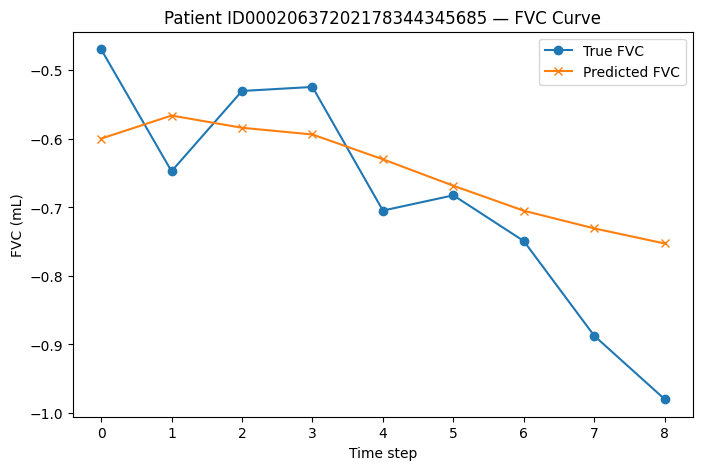

In [ ]:
i = 0  # pick a patient
x_sample = X_val[i:i+1]
y_true = y_val[i]
y_pred = M1.predict(x_sample)[0]  # remove batch dimension

# mask padded zeros
mask = y_true[:,0] != 0  

plt.figure(figsize=(8,5))
plt.plot(y_true[mask,0], label="True FVC", marker='o')
plt.plot(y_pred[mask,0], label="Predicted FVC", marker='x')
plt.title(f"Patient {patients_val[i]} — FVC Curve")
plt.xlabel("Time step")
plt.ylabel("FVC (mL)")
plt.legend()
plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_n_patients(model, X_val, y_val, patients_val, feature_cols, n=5):
    """
    Plots True FVC, GRU-predicted FVC, and optional GP mean (if in feature_cols)
    for the first n patients in the validation set.
    """
    n_patients = min(n, X_val.shape[0])

    # check if gp_mean and Weeks exist in features
    has_gp = "gp_mean" in feature_cols
    gp_idx = feature_cols.index("gp_mean") if has_gp else None

    has_weeks = "Weeks" in feature_cols
    weeks_idx = feature_cols.index("Weeks") if has_weeks else None

    # get predictions for those n patients
    y_val_pred = model.predict(X_val[:n_patients])

    for i in range(n_patients):
        x_seq = X_val[i]                # (T_max, num_features)
        y_true_seq = y_val[i, :, 0]     # (T_max,)
        y_pred_seq = y_val_pred[i, :, 0]  # (T_max,)

        # mask out padded timesteps (assuming padded y_true == 0)
        mask = y_true_seq != 0

        if has_weeks:
            x_axis = x_seq[mask, weeks_idx]
            x_label = "Weeks"
        else:
            x_axis = np.arange(mask.sum())
            x_label = "Time step index"

        plt.figure(figsize=(7, 4))

        # GP mean if available
        if has_gp:
            gp_seq = x_seq[mask, gp_idx]
            plt.plot(x_axis, gp_seq, linestyle="--", label="GP mean")

        # True vs GRU
        plt.plot(x_axis, y_true_seq[mask], marker="o", label="True FVC")
        plt.plot(x_axis, y_pred_seq[mask], marker="x", label="GRU predicted FVC")

        plt.title(f"Patient {patients_val[i]}")
        plt.xlabel(x_label)
        plt.ylabel("FVC (mL)")
        plt.legend()
        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


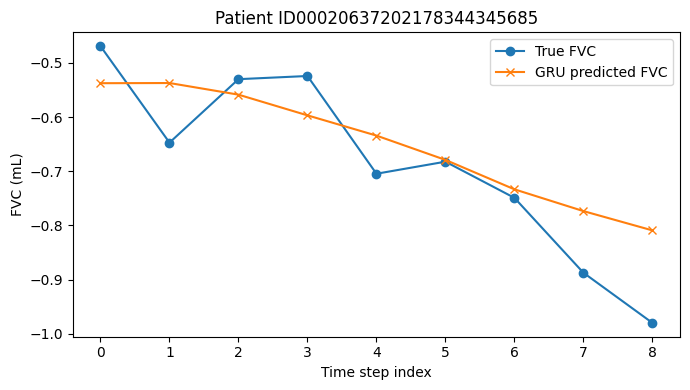

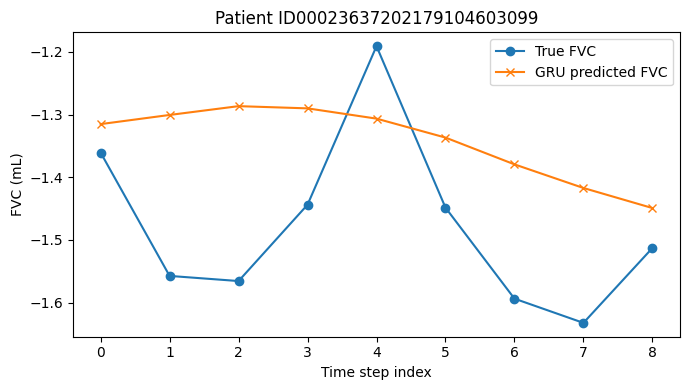

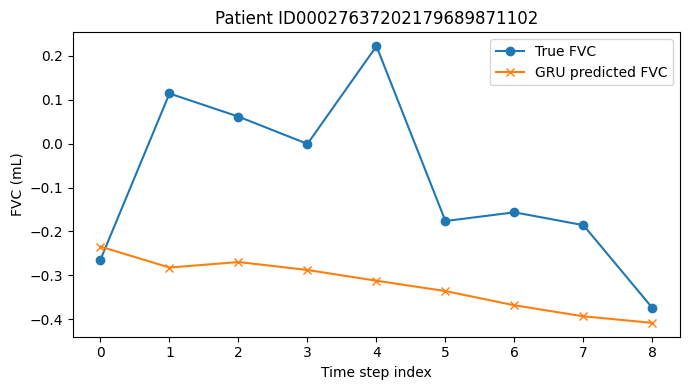

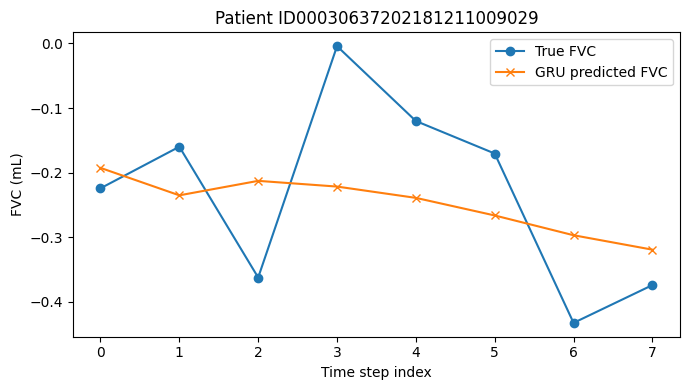

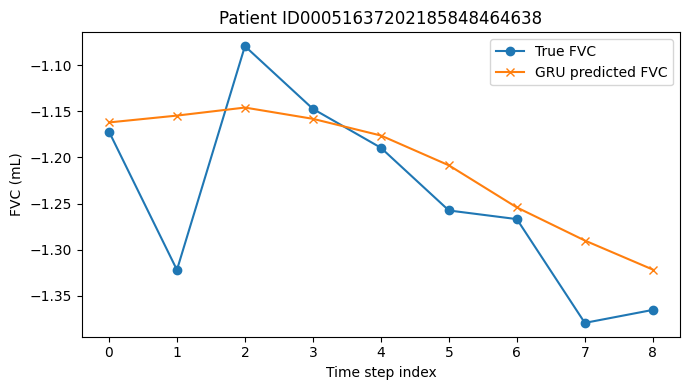

In [41]:
plot_n_patients(model, X_val, y_val, patients_val, feature_cols, n=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


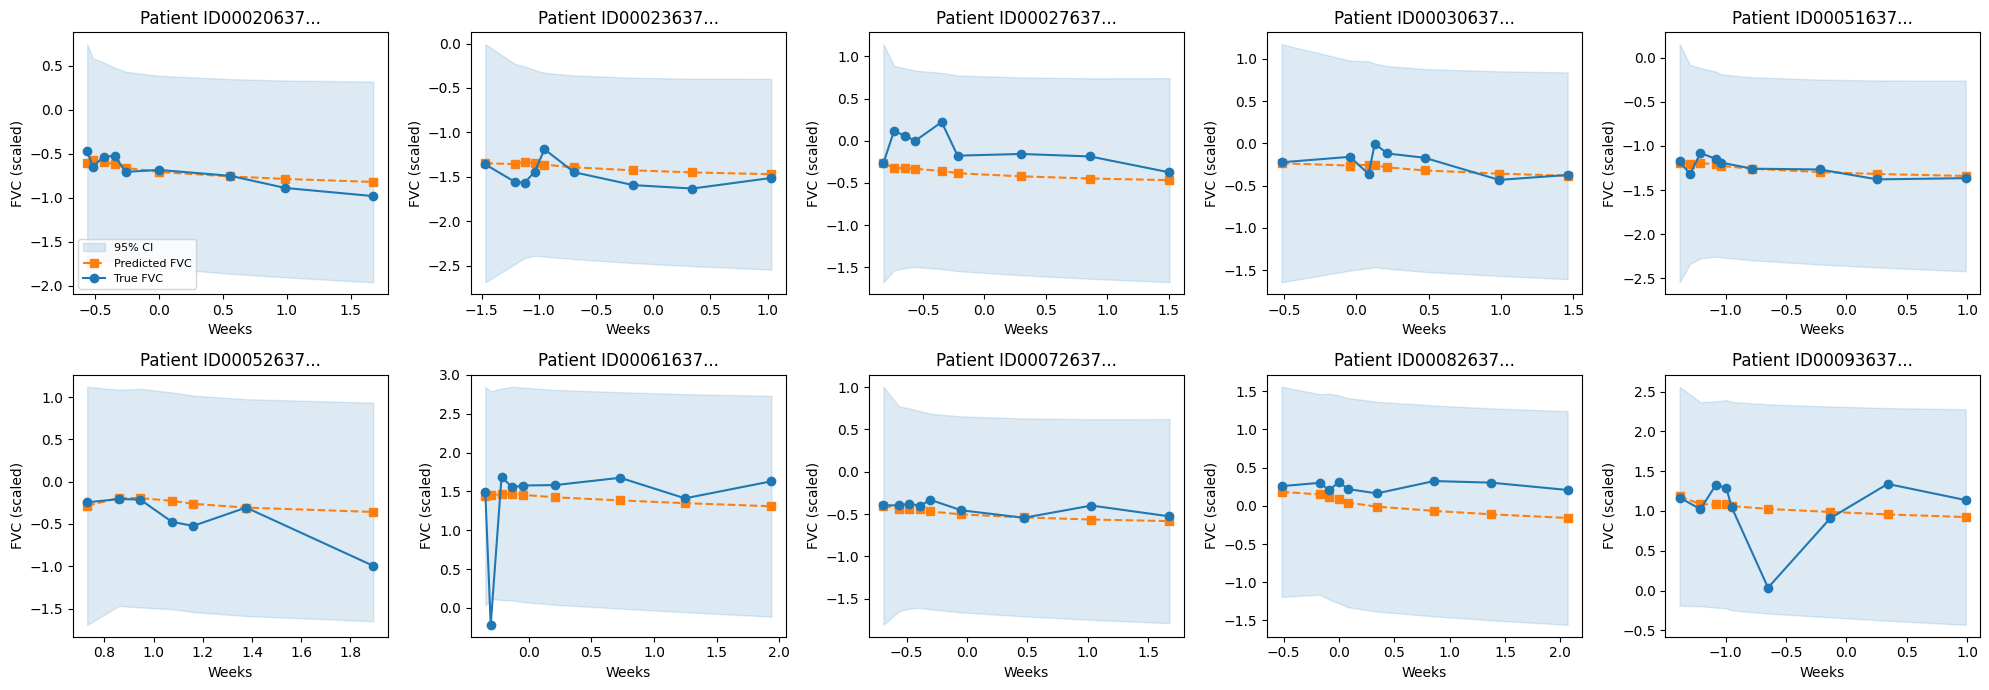

In [54]:
def softplus_np(x):
    # numerically stable softplus, similar to tf.nn.softplus
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def plot_patient_grid_with_ci(
    model,
    X_val,
    y_val,
    patients_val,
    feature_cols,
    n_patients=10,
    n_cols=5
):
    """
    Create a grid of subplots:
      - Blue line:    true FVC
      - Orange line:  predicted mean FVC (mu)
      - Blue band:    95% CI (mu ± 1.96 * sigma)

    Assumes model output: (batch, T, 2) = [mu, log_sigma]
    """
    assert "Weeks_scaled" in feature_cols, "Weeks must be in feature_cols."
    weeks_idx = feature_cols.index("Weeks_scaled")

    n_patients = min(n_patients, X_val.shape[0])
    n_rows = int(np.ceil(n_patients / n_cols))

    # get predictions for the first n_patients
    y_pred = model.predict(X_val[:n_patients])  # (n_patients, T_max, 2)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)  # ensure 2D

    for i in range(n_patients):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]

        x_seq      = X_val[i]            # (T_max, F)
        y_true_seq = y_val[i, :, 0]      # (T_max,)
        mu_seq     = y_pred[i, :, 0]     # (T_max,)
        logsig_seq = y_pred[i, :, 1]     # (T_max,)

        # mask padded timesteps (assuming padded y_true == 0)
        mask = y_true_seq != 0.0

        weeks = x_seq[mask, weeks_idx]
        y_true = y_true_seq[mask]
        mu = mu_seq[mask]
        sigma = softplus_np(logsig_seq[mask]) + 1e-6  # >0

        # 95% confidence interval: mu ± 1.96 * sigma
        upper = mu + 1.96 * sigma
        lower = mu - 1.96 * sigma

        # shaded CI
        ax.fill_between(weeks, lower, upper, color="C0", alpha=0.15, label="95% CI")

        # predicted mean (orange, dashed, square markers)
        ax.plot(weeks, mu, color="C1", linestyle="--", marker="s",
                label="Predicted FVC")

        # true FVC (blue, solid, circle markers)
        ax.plot(weeks, y_true, color="C0", marker="o", label="True FVC")

        # make title shorter if patient ID is long
        pid_str = str(patients_val[i])
        if len(pid_str) > 10:
            pid_str = pid_str[:10] + "..."
        ax.set_title(f"Patient {pid_str}")

        ax.set_xlabel("Weeks")
        ax.set_ylabel("FVC (scaled)")   # or "FVC (mL)" if not scaled

        # only show legend for first subplot to avoid clutter
        if i == 0:
            ax.legend(loc="lower left", fontsize=8)
        else:
            ax.legend_.remove() if ax.get_legend() else None

    # hide any unused axes
    for j in range(n_patients, n_rows * n_cols):
        row = j // n_cols
        col = j % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

plot_patient_grid_with_ci(
    M2,
    X_val,
    y_val,
    patients_val,
    feature_cols,
    n_patients=10,   # 10 plots like your screenshot
    n_cols=5         # 2 rows × 5 columns
)

